In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections.abc import Callable
from datetime import datetime

In [33]:
class NeuralNetwork:
	def __init__(
		self, 
		layers_structure: list[int], 
		parameters: np.ndarray | None = None, 
		activation: list[str] | str = 'sigmoid'
	) -> None:
		self.layers_structure: list[int] = layers_structure
		
		# number of layers, except the input layer
		self._L: int = len(layers_structure) - 1

		# calculation of the correct number of parameters 
		self._NUMBER_OF_PARAMS: int = 0
		for i in range(self._L):
			# number of weights
			self._NUMBER_OF_PARAMS += self.layers_structure[i] * self.layers_structure[i+1]

			# number of biases
			self._NUMBER_OF_PARAMS += self.layers_structure[i+1]
		
		
		self._weights_shapes: list[tuple[int]] = []
		self._biases_shapes: list[tuple[int]] = []
		# computing the appropriate shape of each weights matrix between layers
		for i in range(self._L):
			self._weights_shapes.append((self.layers_structure[i+1], self.layers_structure[i]))
			self._biases_shapes.append((self.layers_structure[i+1], 1))
		
		
		#? if the parameters is passed to __init__, then we'll set the weights and biases based on that
		if type(parameters) == np.ndarray:
			# check the shape before assignment
			if (s := max(parameters.shape)) != self._NUMBER_OF_PARAMS:
				raise ValueError(f'parameters should be of shape ({self._NUMBER_OF_PARAMS}, 1). Got {s} instead.')
			
			self.parameters: np.ndarray = parameters
			
			# setting both self.weights and self.biases, based on parameters
			self.parse_parameters()

		#? if parameters is not passed to __init__ we'll set them randomly
		else:
			self.weights: list[np.ndarray] = [np.random.randn(*shape) for shape in self._weights_shapes]
			self.biases: list[np.ndarray] = [np.random.randn(*shape) for shape in self._biases_shapes]

			# sets self.parameters, based on weights and biases
			self.recompute_parameters()

			
		#* type of activation
		# if only a str, apply it to all layers
		# if a list with size L(number_of_layers except input layer), apply individual activations
		if type(activation) == str:
			activation: list[str] = [activation for _ in range(self._L)]
		
		if len(activation) != self._L:
			raise ValueError(
				f'activation list should be of size [len(layers_structure)-1]={self._L}.\n Got {len(activation)} instead.'
			)
		
		self.activation: list[Callable] = []
		self.d_activation: list[Callable] = []
		
		for act in activation:
			match act:
				case 'sigmoid':
					self.activation.append(NeuralNetwork._sigmoid)
					self.d_activation.append(NeuralNetwork._d_sigmoid)
				case 'tanh':
					self.activation.append(NeuralNetwork._tanh)
					self.d_activation.append(NeuralNetwork._d_tanh)
				case 'relu':
					self.activation.append(NeuralNetwork._ReLU)
					self.d_activation.append(NeuralNetwork._d_ReLU)
				case 'no-activation':
					self.activation.append(lambda x: x)
					self.d_activation.append(lambda x: x)
				case _:
					raise ValueError('activations can be a member of ["sigmoid", "relu", "tanh", "no-activation"]')
		
		# initialize all the neurons with zero
		self.input_layer: np.ndarray = np.zeros((self.layers_structure[0], 1))

		# to initialize all z, and activations
		self.z_layers = [None for _ in range(self._L)]
		self.layers = [None for _ in range(self._L)]

		self.feed_forward()
		# input layer has no z or activation
		#self.z_layers: list[np.ndarray] = [np.zeros(shape=(num, 1)) for num in layers_structure[1:]]
		#self.layers: list[np.ndarray] = [af(z) for af, z in zip(self.activation, self.z_layers)]


	def load_input_layer(self, input_vector: np.ndarray) -> None:
		#* input_vector.shape = (self.layers_structure[0], 1)
		if input_vector.shape != (self.layers_structure[0], 1):
			raise ValueError(f'input should be of shape {(self.layers_structure[0], 1)}. got {input_vector.shape} instead')
		
		self.input_layer = input_vector
		

	def cost_of_single_sample(self, sample: np.ndarray, true_label: int, one_hot: bool = True) -> float:
		#* input_vector.shape = (self.layers_structure[0], 1)
		if sample.shape != (self.layers_structure[0], 1):
			raise ValueError(f'input should be of shape {(self.layers_structure[0], 1)}. got {sample.shape} instead')

		self.load_input_layer(input_vector=sample)
		self.feed_forward()
		
		if one_hot:
			# construct the output vector based on the label
			desired_output = np.zeros((self.layers_structure[-1], 1))
			desired_output[true_label] = 1.0
		
		# compare the self.layers[-1] and the desired_output
		# using mean squared error
		cost = np.sum((self.layers[-1] - desired_output)**2)
		return cost
	

	def cost_of_test_data(self, test_samples: np.ndarray, true_labels: np.ndarray, one_hot: bool = True) -> float:
		"""
			samples.shape = (self.layers_structure[0], m)
			true_labels.shape = (1, m)
			samples: is a np array which each col represents one sample			
		"""
		

		MSE: float = 0
		for sample, label in zip(test_samples.T, true_labels[0]):
			sample = sample.reshape((-1, 1))
			MSE += self.cost_of_single_sample(sample, label)
		
		M = len(test_samples.T)
		MSE = (1 / M) * MSE
		return MSE
	

	def accuracy_score(self, test_samples: np.ndarray, true_labels: np.ndarray) -> float:
		#* test_samples.shape = (self.layer_structure[0], m)
		#* true_labels.shape = (1, m)

		total: int = len(test_samples.T)
		trues: int = 0

		for sample, label in zip(test_samples.T, true_labels[0]):
			sample = sample.reshape((-1, 1))
			result = self.predict(sample)
			if result == label:
				trues += 1
		
		return (trues / total)


	def predict_v(self, sample: np.ndarray) -> np.ndarray:
		#* sample.shape = (self.layers_structure[0], 1)
		if sample.shape != (self.layers_structure[0], 1):
			raise ValueError(f'{sample.shape} is a bad shape for input. should be {(self.layers_structure[0], 1)}.')

		self.load_input_layer(input_vector=sample)
		self.feed_forward()
		
		return self.layers[-1]

	
	def predict(self, sample: np.ndarray) -> int:
		output_vector = self.predict_v(sample)
		return np.argmax(output_vector)


	def _backprop_one_sample(self, sample: np.ndarray, label: int) -> tuple:
		"""
			This method holds all the math and calculus behind backpropagation
			it calculates the derivitive of the cost w.r.t all the weights and
			biases of the network, for only ONE training data
		"""
		
		self.load_input_layer(input_vector=sample)
		self.feed_forward()

		#* convert the label in int format into a one-hot vector
		desired_output = np.zeros(self.layers[-1].shape)
		desired_output[label] = 1.0
		
		#* d_cost_p_ol.shape = (self.layers_structure[-1], 1)
		#* derivative of mean squared error
		d_cost_p_ol = 2 * (self.layers[-1] - desired_output)

		#* d_activation(z_ol)
		#* times the gradient of the cost w.r.t activations of the output layer
		#* error_ol.shape =(self.layers_structure[-1], 1)
		error_ol = self.d_activation[-1](self.z_layers[-1]) *  d_cost_p_ol
		
		# error of all the other layers, except the last layer and the input layer
		#* this errors are gonna be in reverse order, so the first item will be the second to last layer's
		#* and the next will be the third from last layer's and so on ...
		hlayers_errors: list[np.ndarray] = []

		
		# loop through hidden layers in reverse order, from secnod to last layer, to the second layer
		# L-2 is because we should start at the last hidden layer
		e_count = 0
		for i in range(self._L - 2, -1, -1):
			#* the layer before the output layer
			if i == self._L - 2:
				e = self.d_activation[i](self.z_layers[i]) * (self.weights[i+1].T @ error_ol)
				hlayers_errors.append(e)
			else:
				#* remember errors[L-2-i] should be used, and it actually means the error of the next layer
				#* this is because it is in the reveresed order
				#e = self.d_activation[i](self.z_layers[i]) * (self.weights[i+1].T @ hlayers_errors[self.L-2-i])
				e = self.d_activation[i](self.z_layers[i]) * (self.weights[i+1].T @ hlayers_errors[e_count])
				e_count += 1
				hlayers_errors.append(e)

		#* now we can flip the errors for convenience
		hlayers_errors = hlayers_errors[::-1]
		
		# of length L
		d_cost_p_biases: list[np.ndarray] = []
		#* based on the equations of backprpoagation we know that d_cost_p_b of each layer
		#* is actually equal to the error of that layer.
		for error in hlayers_errors:
			d_cost_p_biases.append(error)
		d_cost_p_biases.append(error_ol)


		#* based on the equations of backpropagation
		#* the derivative of the cost wr to the weights of the layer l will be
		#* the matrix mult of error of layer l and activation of layer l-1 transposed
		d_cost_p_weights: list[np.ndarray] = []

		d_cost_p_weights.append(hlayers_errors[0] @ self.input_layer.T)
		for i in range(1, self._L - 1):
			d_cost_p_weights.append(error[i] @ self.layers[i-1].T)
		d_cost_p_weights.append(error_ol @ self.layers[-2].T)


		return (d_cost_p_weights, d_cost_p_biases)

	
	def backpropagation(self, x_train: np.ndarray, y_train: np.ndarray) -> tuple:
		"""
			This method will run the backprop_one_sample method for a dataset and 
			take the average of all the gradients of the weights and biases
		"""

		#* m training samples
		#* x_train.shape = (self.layers_structure[0], m)
		#* y_train.shape = (1, m)
		
		# average derivative of cost w.r.t weights
		dw: list[np.ndarray] = [np.zeros(shape) for shape in self._weights_shapes]
		
		# average derivative of cost w.r.t biases
		db: list[np.ndarray] = [np.zeros(shape) for shape in self._biases_shapes]

		for features, label in zip(x_train.T, y_train[0]):
			#* label: int
			#* features.shape = (self.layers_structure[0], 1)
			features = features.reshape((-1, 1))

			#* label in this method should be an int
			tdw, tdb = self._backprop_one_sample(sample=features, label=label)
			
			for i in range(self._L):
				dw[i] += tdw[i]
				db[i] += tdb[i]
			
		#* now each element in the dw and db contain the sum of the derivatives of 
		#* the samples inside the training data
		#* now they should be divided by the number of the train sample size, so dw and db, be an average
		train_data_size = x_train.shape[1]
		
		for i in range(self._L):
			dw[i] /= train_data_size
			db[i] /= train_data_size

		#* now they contain the gradient of the provided dataset
		return (dw, db)
			

	def recompute_parameters(self) -> None:
		"""
			This method will recompute self.parameters from the current self.weights and self.biases
		"""
		self.parameters = np.array([])
		# first the weights
		for ws in self.weights:
			self.parameters = np.append(self.parameters, ws.flatten())
		# then the biases
		for bs in self.biases:
			self.parameters = np.append(self.parameters, bs.flatten())

		
		self.parameters = self.parameters.reshape((-1, 1))


	def init_weights_biases(self, weights: list[np.ndarray], biases: list[np.ndarray]) -> None:
		if len(weights) != self._L:
			raise ValueError(f'Weights list should contain {self._L} weights matrices!')
		
		for i, (ws, shape) in enumerate(zip(weights, self._weights_shapes)):
			if ws.shape != shape:
				raise ValueError(f'{ws.shape} is a wrong shape.(happened in weights[{i}]) should be {shape}.')

		for i, (bs, shape) in enumerate(zip(biases, self._biases_shapes)):
			if bs.shape != shape:
				raise ValueError(f'{bs.shape} is a wrong shape.(happened in biases[{i}]) should be {shape}.')

		self.weights: list[np.ndarray] = weights
		self.biases: list[np.ndarray] = biases
		self.recompute_parameters()


	def _update_parameters(self, dw, db, learning_rate) -> None:
		self.weights = [
			weights_matrix - (learning_rate * dw[i])
			for i, weights_matrix in enumerate(self.weights)
		]

		self.biases = [
			biases_vector - (learning_rate * db[i])
			for i, biases_vector in enumerate(self.biases)
		]

		#* now self.parameters, which basically is the flattened version of 
		#* all the weights and biases, should be updated as well
		self.recompute_parameters()


	def parse_parameters(self, parameters: np.ndarray | None = None) -> None:
		"""
			This method will parse self.parameters and set each parameter to the corresponding
			weights and biases
		"""
		# if the parameters is passed and is of correct shape, update the parameters
		if type(parameters) == np.ndarray:
			if parameters.shape != (self._NUMBER_OF_PARAMS, 1):
				raise ValueError(f'parameters should be of shape {(self._NUMBER_OF_PARAMS, 1)}.')
			
			self.parameters = parameters

		self.weights: list[np.ndarray] = []
		self.biases: list[np.ndarray] = []
		
		# grab the parameters for weights
		count: int = 0
		for shape in self._weights_shapes:
			total = shape[0] * shape[1]
			ws = self.parameters.T[0][count:count+total].reshape(shape)
			self.weights.append(ws)

			count += total
		
		# grab the parameters for biases
		for shape in self._biases_shapes:
			total = shape[0]
			bs = self.parameters.T[0][count:count+total].reshape(shape)
			self.biases.append(bs)

			count += total


	def train(
			self, 
			x_train: np.ndarray, 
			y_train: np.ndarray,
			*,
			learning_rate: float = 0.1,
			constant_lr: bool = False,
			decay_rate: float = 0.1,
			number_of_epochs: int = 80,
			mini_batches_size: int = 100
	) -> None:
		"""Trains the model with the labeled training data"""

		#* initialize the parameters randomly
		#* it is assumed that the parameters are initialized randomly
		
		#* m training samples
		#* x_train.shape = (self.layers_structure[0], m)
		#* y_train.shape = (1, m)
		
		#* first we'd better attach the x_train and y_train together
		#* then we can shuffle the training data
		#* and then seperate the x and y again
		#* add y row to the 0-th row of train_data
		train_data = np.vstack((y_train, x_train))

		#! now because shuffle, shuffles the array based on the rows
		#! but we need to shuffle the data based on the coloumns
		#! we have to transpose it twice to get around this
		train_data = train_data.T
		np.random.shuffle(train_data)
		train_data = train_data.T

		#* now that the data is shuffled properly
		#* we should divide the data into mini-batches
		mini_batches: list[np.ndarray] = [
			train_data[:, count:count+mini_batches_size]
			for count in range(0, len(train_data.T), mini_batches_size)
		]


		#* keep track of the accuracy scores, to plot later	
		scores: list[float] = []

		initial_lr: float = learning_rate
		for epoch in range(number_of_epochs):
			#* now each mini-batch corresponds to one step at gradient descent
			#* batch.shape = (self.layers_structure[0]+1, mini_batches_size), the label and the features
			for batch in mini_batches:
				#* batch.shape = (self.layers_structure[0]+1, mini_batches_size)
				x_train_batch = batch[1:] # (self.layers_structure[0], mini_batches_size)
				y_train_batch = batch[0:1] # (1, mini_batches_size)

				# now because y_train_batch holds the labels, and they should be int
				# int8 is enough because we know labels are single digit ints
				y_train_batch = y_train_batch.astype(np.int8)

				#* the backprop algorithm will run for each batch, one step downhill towards a local minima
				#* it also updates the self.layers[-1](output layer)
				#* and consequently the cost, by running self.feed_forward
				dw, db = self.backpropagation(x_train_batch, y_train_batch)

				if constant_lr:
					lr = learning_rate
				else:
					lr = np.exp(-epoch * decay_rate) * initial_lr


				#* change each of the weights and biases accordingly
				self._update_parameters(dw, db, learning_rate=lr)
			
			#* parameters are updated now
			score = self.accuracy_score(x_train, y_train)*100				
			scores.append(score)
			print(f'epoch {epoch+1}: {score:.2f}%')

		self.plot_scores(list(range(1, number_of_epochs+1)), scores)

		
	def plot_scores(self, epochs_range: list[int], scores: list[float]) -> None:
		fig = plt.figure()
		fig.tight_layout()
		plt.title('Accuracy Score per Epoch')
		plt.xlabel('Epoch')
		plt.ylabel('Accuracy Score')
		plt.xticks(epochs_range)
		plt.plot(epochs_range, scores)
		plt.show()
				
	@staticmethod
	def _sigmoid(z: np.ndarray) -> np.ndarray:
		return 1 / (1 + np.exp(-z))

	@staticmethod
	def _d_sigmoid(z: np.ndarray) -> np.ndarray:
		return np.exp(-z) / (np.pow((1 + np.exp(-z)), 2))


	@staticmethod
	def _ReLU(z: np.ndarray) -> np.ndarray:
		return np.maximum(0, z)
	
	
	@staticmethod
	def _d_ReLU(z: np.ndarray) -> np.ndarray:
		return (z > 0).astype(np.float64)
	

	@staticmethod
	def _tanh(z: np.ndarray) -> np.ndarray:
		return np.tanh(z)

	
	@staticmethod
	def _d_tanh(z: np.ndarray) -> np.ndarray:
		return 4 * np.exp(2 * z) / np.power(np.exp(2*z) + 1, 2)


	@staticmethod
	def _softmax(z: np.ndarray) -> np.ndarray:
		return np.exp(-z) / np.sum(np.exp(-z))


	def feed_forward(self) -> None:
		"""
			Will calculate all the values in all the layers 
			based on the weights and biases 
		"""

		# loop through each layer(except input layer) and calculate the z of the next layer
		# and the activation of the current
		for i in range(self._L):
			# connection between the input layer and the next layer
			if i == 0:
				self.z_layers[i] = (self.weights[0] @  self.input_layer) + self.biases[0]
			else:
				self.z_layers[i] = (self.weights[i] @ self.layers[i-1]) + self.biases[i]

			self.layers[i] = self.activation[i](self.z_layers[i])


		if self.layers[-1].shape != (self.layers_structure[-1], 1):
			raise ValueError(f'{self.layers[-1].shape} is a bad shape! Should be {(self.layers_structure[-1], 1)}')


	def print_network(self, hidden_layers = False) -> None:
		if hidden_layers:
			# all hidden layers, all layers except output layer
			for i, layer in enumerate(self.layers[:-1]):
				print(f'layer {i}: {layer}')

		print(f'Output layer:\n{self.layers[-1]}')


	def plot_network(self):
		layers = [
			l.reshape((-1,))
			for l in self.layers		
		]

		fig, ax = plt.subplots()
		
		# Determine the positions for the layers
		layer_sizes = [len(layer) for layer in layers]
		v_spacing = max(layer_sizes) + 1 + 3  # Vertical spacing between neurons
		h_spacing = 15  # Horizontal spacing between layers
		
		# Iterate over layers
		for i, layer in enumerate(layers):
			y_pos = np.linspace(v_spacing / 2, -v_spacing / 2, len(layer))
			x_pos = np.full_like(y_pos, i * h_spacing)
			
			# Plot neurons
			for j, neuron_value in enumerate(layer):
				circle = plt.Circle((x_pos[j], y_pos[j]), radius=0.4, facecolor=str(neuron_value), edgecolor='k')
				ax.add_artist(circle)
				# Optional: Add text to show the neuron value
				ax.text(x_pos[j]+1.5, y_pos[j], f'{neuron_value:.2f}', ha='center', va='center', color='black')

			# Draw connections (optional)
			if i > 0:
				prev_layer = layers[i - 1]
				prev_y_pos = np.linspace(v_spacing / 2, -v_spacing / 2, len(prev_layer))
				prev_x_pos = np.full_like(prev_y_pos, (i - 1) * h_spacing)
				for k in range(len(prev_layer)):
					for l in range(len(layer)):
						ax.plot([prev_x_pos[k], x_pos[l]], [prev_y_pos[k], y_pos[l]], 'k-', lw=0.04)

		ax.set_aspect('equal')
		ax.axis('off')
		plt.tight_layout()
		plt.show()

		
	def print_stat(self, x_test: np.ndarray, y_test: np.ndarray) -> None:
		score = self.accuracy_score(x_test, y_test)
		cost = self.cost_of_test_data(x_test, y_test)

		print(f'Accuracy = {score * 100:.2f}%')
		print(f'Cost = {cost:.3f}')
	

	def	load_params_from_file(self, filename: str) -> None:
		with open(filename, 'r') as file:
			ps = [float(line.strip()) for line in file.readlines()]

		self.parse_parameters(np.array(ps).reshape((-1, 1)))


	def save_parameters_to_file(self, filename: str | None = None) -> None:
		if not filename:
			filename = f"parameters_{datetime.now().strftime('%y_%m_%d_%H_%M')}.txt"
		with open(filename, 'w') as file:
			for p in self.parameters.reshape((-1, )):
				file.write(f'{p}\n')


In [67]:
def show_sample(sample: np.ndarray):
		#* sample.shape = (784, 1)
		matrix = np.array(sample).reshape(28, 28)
		matrix *= 255
		plt.imshow(matrix, cmap='gray', vmin=0, vmax=255)
		plt.axis('off')
		plt.show()

In [7]:
train_df = pd.read_csv('./data/mnist_train.csv')
test_df = pd.read_csv('./data/mnist_test.csv')

x_train = np.array(train_df.iloc[:, 1:]).transpose() # shape = 784 * m, so each col is a sample
x_train = (x_train / 255.0).astype(np.float64) # to squish the pixel values between 0-1 instead of 0-255
y_train = np.array(train_df.iloc[:, 0:1]).reshape((1, -1)) # shape = 1 * m

x_test = np.array(test_df.iloc[:, 1:]).transpose()
x_test = (x_test / 255.0).astype(np.float64)
y_test = np.array(test_df.iloc[:, 0:1]).reshape((1, -1))

In [56]:
np.random.seed(42)
NN = NeuralNetwork(layers_structure=[784, 10, 10], activation='sigmoid')

#weights = [np.random.randn(*shape) * np.sqrt(1. / shape[1]) for shape in NN._weights_shapes]
#biases = [np.random.randn(*shape) for shape in NN._biases_shapes]
#NN.init_weights_biases(weights, biases)
#NN.load_params_from_file(filename='randomparams')


In [57]:
NN._NUMBER_OF_PARAMS

7960

In [54]:
NN.print_stat(x_test, y_test)

Accuracy = 12.99%
Cost = 3.976


epoch 1: 58.42%
epoch 2: 74.13%
epoch 3: 79.91%
epoch 4: 82.54%
epoch 5: 84.07%
epoch 6: 85.07%
epoch 7: 85.69%
epoch 8: 86.23%
epoch 9: 86.58%
epoch 10: 86.91%
epoch 11: 87.17%
epoch 12: 87.35%
epoch 13: 87.55%
epoch 14: 87.72%


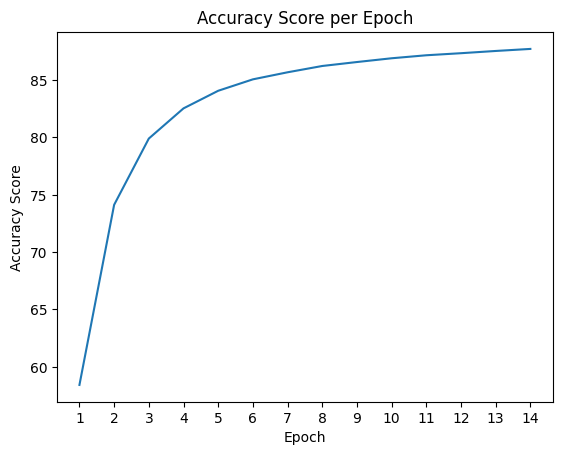

In [58]:
NN.train(x_train, y_train, number_of_epochs=14, mini_batches_size=120, learning_rate=1, constant_lr=False)

In [59]:
NN.print_stat(x_train, y_train)
NN.print_stat(x_test, y_test)

Accuracy = 87.72%
Cost = 0.195
Accuracy = 87.54%
Cost = 0.196


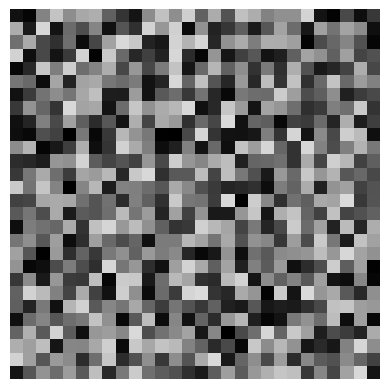

/tmp/ipykernel_23136/3585318237.py:457: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


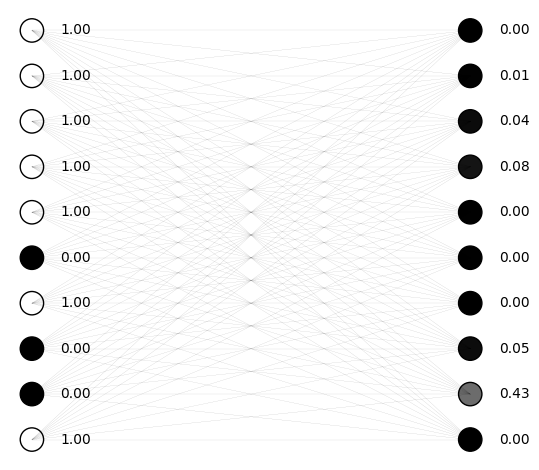

In [60]:
noise = np.random.randint(0, 220, size=(784, 1))
NN.show_sample(noise)
NN.load_input_layer(noise)
NN.feed_forward()
NN.plot_network()

In [42]:
custom_df = pd.read_csv('./custom_data.csv')
custom_test_x = np.array(custom_df).T
custom_test_x.shape

(784, 10)

0
[[3.81520890e-01]
 [1.61756287e-03]
 [1.53063179e-03]
 [8.40094862e-04]
 [1.50862396e-04]
 [2.47231870e-01]
 [1.43065701e-01]
 [1.11562782e-02]
 [1.56999523e-01]
 [3.68267328e-05]]


/tmp/ipykernel_23136/3585318237.py:457: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


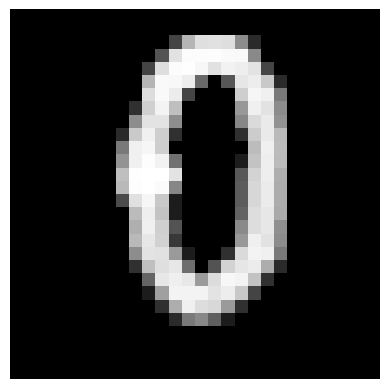

1
[[1.26440519e-03]
 [9.60310092e-01]
 [3.58816195e-02]
 [4.66905131e-03]
 [1.58750850e-05]
 [2.89692755e-03]
 [6.47262035e-02]
 [3.32047770e-02]
 [5.88102466e-02]
 [3.50731552e-04]]


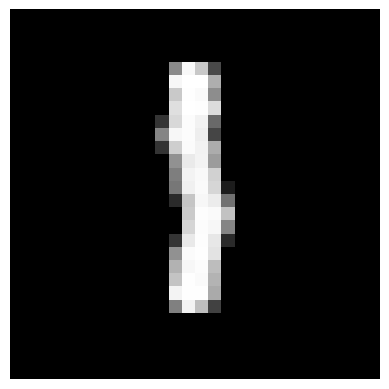

2
[[8.21222371e-03]
 [9.80368915e-03]
 [9.75408794e-01]
 [2.88842769e-02]
 [1.99745654e-04]
 [8.56610931e-04]
 [3.87980709e-02]
 [5.01173237e-03]
 [1.49813853e-02]
 [6.13815187e-05]]


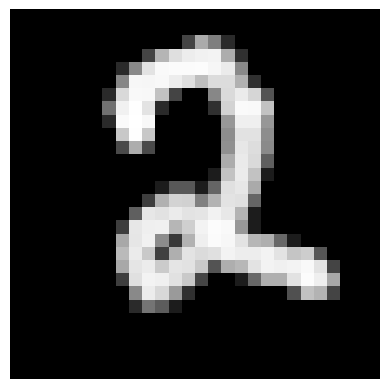

2
[[2.78347258e-03]
 [3.13084772e-02]
 [9.40664570e-01]
 [8.06891454e-02]
 [2.13339421e-03]
 [4.70334104e-04]
 [2.78354625e-03]
 [9.69608198e-03]
 [3.18684310e-03]
 [9.73235894e-06]]


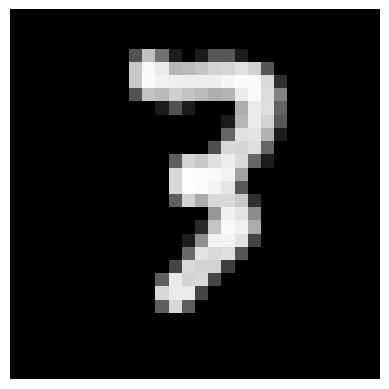

4
[[6.32511423e-06]
 [1.00441226e-04]
 [3.42774213e-04]
 [1.68443167e-01]
 [7.11911179e-01]
 [2.28620773e-02]
 [2.75614219e-04]
 [5.93000413e-04]
 [1.08864644e-02]
 [2.34721728e-01]]


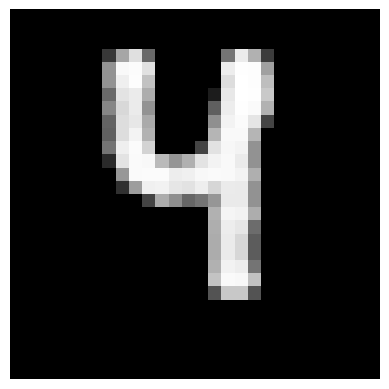

3
[[4.10589054e-06]
 [2.03088675e-04]
 [9.21154546e-04]
 [2.09812274e-01]
 [4.82222335e-02]
 [1.19291697e-02]
 [5.89667004e-03]
 [3.94680649e-02]
 [2.44831788e-03]
 [3.59686242e-03]]


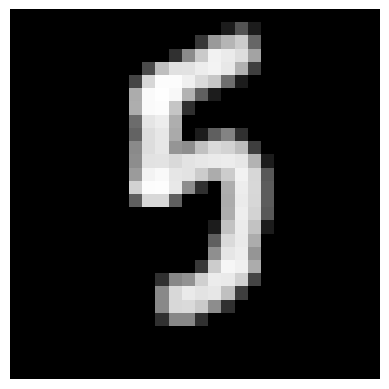

8
[[2.44753745e-01]
 [8.72280936e-05]
 [3.74442718e-03]
 [1.07861256e-03]
 [3.53879637e-02]
 [2.35795298e-01]
 [3.23690851e-03]
 [1.44217656e-03]
 [4.97676807e-01]
 [7.20421658e-03]]


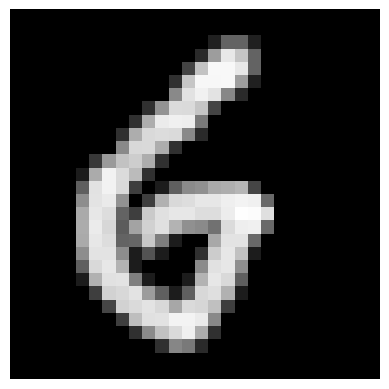

2
[[2.24094328e-02]
 [8.02789693e-04]
 [5.35002420e-01]
 [3.36291540e-01]
 [5.21150967e-04]
 [4.94158235e-04]
 [9.08070331e-05]
 [4.84216904e-02]
 [2.78675318e-02]
 [3.74935758e-05]]


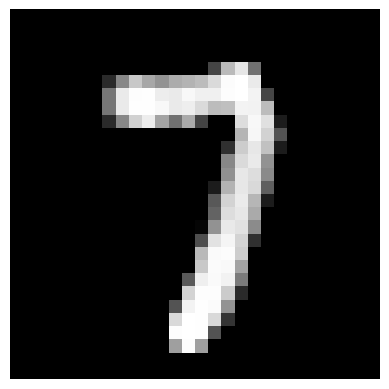

6
[[3.59284904e-05]
 [3.61654760e-03]
 [2.23792722e-01]
 [3.23386059e-04]
 [3.21502415e-02]
 [4.35315377e-04]
 [7.50355847e-01]
 [1.53862254e-02]
 [1.31280651e-02]
 [3.48983363e-03]]


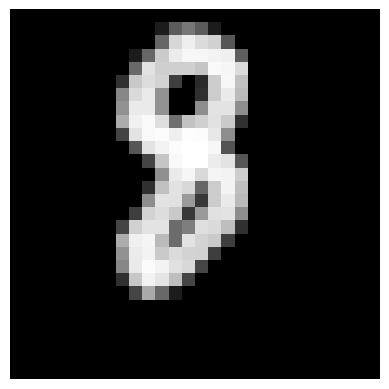

8
[[4.25162744e-03]
 [2.21288844e-03]
 [1.01766505e-01]
 [2.81610048e-02]
 [2.87773375e-04]
 [5.42598701e-03]
 [1.05097554e-02]
 [2.46973567e-02]
 [7.78919802e-01]
 [2.09290065e-04]]


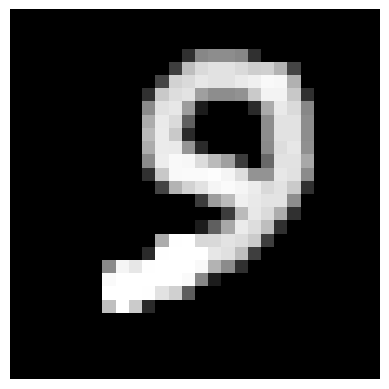

0.4

In [62]:
for sample in custom_test_x.T:
	sample = sample.reshape((-1, 1))
	print(NN.predict(sample))
	print(NN.predict_v(sample))
	NN.show_sample(sample)

NN.accuracy_score(custom_test_x, [list(range(10))])

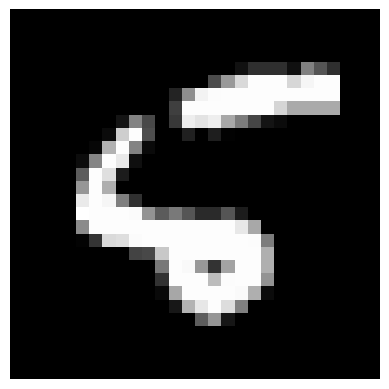

true label: 5
prediction: 0


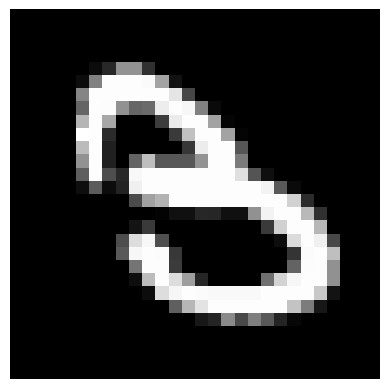

true label: 3
prediction: 8


In [69]:
#* examples where the prediction was not correct
for i, (sample, label) in enumerate(zip(x_test.T, y_test[0])):
	sample = sample.reshape((-1, 1))
	p = NN.predict(sample)
	if p != label:
		show_sample(sample)
		print(f'true label: {label}')
		print(f'prediction: {p}')
	if i >= 20: break	
